In [1]:
library(rayshader)
library(raster)
library(rgdal)
library(leaflet)

Warning message:
"package 'rayshader' was built under R version 4.2.3"
Warning message:
"package 'raster' was built under R version 4.2.3"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.2.3"
Warning message:
"package 'rgdal' was built under R version 4.2.3"
Please note that rgdal will be retired during 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.
See https://r-spatial.org/r/2022/04/12/evolution.html and https://github.com/r-spatial/evolution
rgdal: version: 1.6-6, (SVN revision 1201)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.5.2, released 2022/09/02
Path to GDAL shared files: C:/Users/lando/AppData/Local/R/win-library/4.2/rgdal/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 8.2.1, January 1st, 2022, [PJ_VERSION: 821]
Path to PROJ shared files: C:/Users/lando/AppData/Local/R/win-library/4.2/rgdal/proj
PROJ CDN enabl

In [10]:
bbox <- list(
  p1 = list(long = -77.10588, lat = 38.9153),
  p2 = list(long = -76.95, lat = 38.82859)
)

In [11]:
#https://github.com/wcmbishop/rayshader-demo/blob/master/R/image-size.R
define_image_size <- function(bbox, major_dim = 400) {
  # calculate aspect ration (width/height) from lat/long bounding box
  aspect_ratio <- abs((bbox$p1$long - bbox$p2$long) / (bbox$p1$lat - bbox$p2$lat))
  # define dimensions
  img_width <- ifelse(aspect_ratio > 1, major_dim, major_dim*aspect_ratio) %>% round()
  img_height <- ifelse(aspect_ratio < 1, major_dim, major_dim/aspect_ratio) %>% round()
  size_str <- paste(img_width, img_height, sep = ",")
  list(height = img_height, width = img_width, size = size_str)
}

image_size <- define_image_size(bbox, major_dim = 600)

In [12]:
#https://github.com/wcmbishop/rayshader-demo/blob/master/R/elevation-api.R
get_usgs_elevation_data <- function(bbox, size = "400,400", file = NULL, 
                                    sr_bbox = 4326, sr_image = 4326) {
  require(httr)
  
  # TODO - validate inputs
  
  url <- parse_url("https://elevation.nationalmap.gov/arcgis/rest/services/3DEPElevation/ImageServer/exportImage")
  res <- GET(
    url, 
    query = list(
      bbox = paste(bbox$p1$long, bbox$p1$lat, bbox$p2$long, bbox$p2$lat,
                   sep = ","),
      bboxSR = sr_bbox,
      imageSR = sr_image,
      size = size,
      format = "tiff",
      pixelType = "F32",
      noDataInterpretation = "esriNoDataMatchAny",
      interpolation = "+RSP_BilinearInterpolation",
      f = "json"
    )
  )
  
  if (status_code(res) == 200) {
    body <- content(res, type = "application/json")
    img_res <- GET(body$href)
    img_bin <- content(img_res, "raw")
    if (is.null(file)) 
      file <- tempfile("elev_matrix", fileext = ".tif")
    writeBin(img_bin, file)
    message(paste("image saved to file:", file))
  } else {
    warning(res)
  }
  invisible(file)
}

In [13]:
elev_file <- file.path("elevation.tif")
get_usgs_elevation_data(bbox, size = image_size$size, file = elev_file,
                        sr_bbox = 4326, sr_image = 4326)

image saved to file: elevation.tif



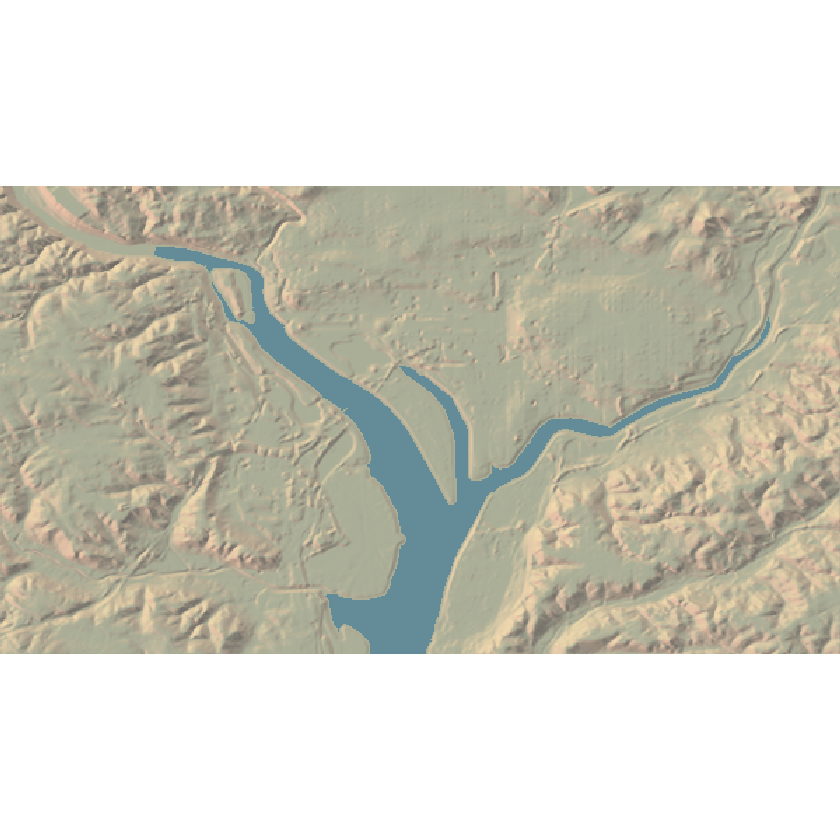

In [14]:
# load elevation data
elev_img <- raster::raster(elev_file)
elev_matrix <- matrix(
  raster::extract(elev_img, raster::extent(elev_img), buffer = 1000), 
  nrow = ncol(elev_img), ncol = nrow(elev_img)
)

# calculate rayshader layers
ambmat <- ambient_shade(elev_matrix, zscale = 30)
raymat <- ray_shade(elev_matrix, zscale = 30, lambert = TRUE)
watermap <- detect_water(elev_matrix)

# plot 2D
elev_matrix %>%
  sphere_shade(texture = "imhof4") %>%
  add_water(watermap, color = "imhof4") %>%
  #add_shadow(raymat, max_darken = 0.5) %>%
  #add_shadow(ambmat, max_darken = 0.5) %>%
  plot_map()

Warning message:
"'rgl.surface' is deprecated.
Use 'surface3d' instead.
See help("Deprecated")"
Warning message:
"'rgl.viewpoint' is deprecated.
Use 'view3d' instead.
See help("Deprecated")"
Warning message:
"'rgl::rgl.material' is deprecated.
Use 'material3d' instead.
See help("Deprecated")"
Warning message:
"'rgl.triangles' is deprecated.
Use 'triangles3d' instead.
See help("Deprecated")"


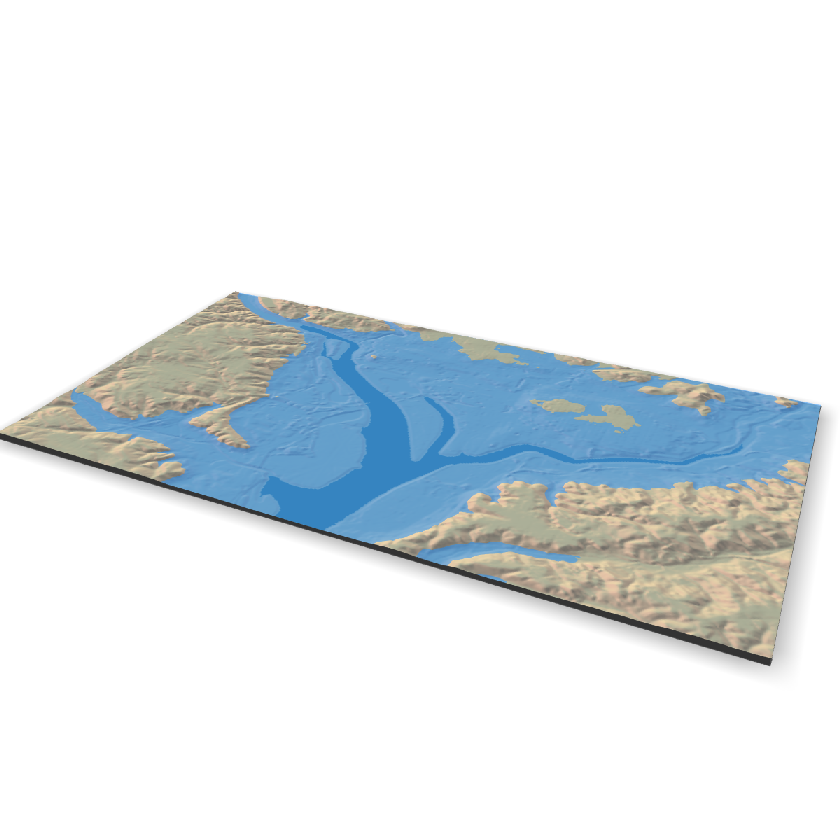

In [15]:
zscale <- 30
elev_matrix %>% 
  sphere_shade(texture = "imhof4") %>% 
  add_water(watermap, color = "imhof3") %>%
  #add_shadow(raymat, max_darken = 0.5) %>%
  #add_shadow(ambmat, max_darken = 0.5) %>%
  plot_3d(elev_matrix, zscale = zscale, windowsize = c(1200, 1000),
          water = TRUE, soliddepth = -max(elev_matrix)/zscale, wateralpha = 0.5,
          waterdepth = 25.741488,
          theta = 25, phi = 30, zoom = 0.65, fov = 60)
render_snapshot()

In [16]:
n_frames <- 100
zscale <- 30
# frame transition variables
waterdepthvalues <- mean(elev_matrix)*1 - mean(elev_matrix)* 1.5 * cos(seq(0,2*pi,length.out = n_frames))
thetavalues <- -90 + 45 * cos(seq(0, 2*pi, length.out = n_frames))
# shadow layers
#ambmat <- ambient_shade(elev_matrix, zscale = zscale)
#raymat <- ray_shade(elev_matrix, zscale = zscale, lambert = TRUE)

# generate .png frame images
img_frames <- paste0("drain", seq_len(n_frames), ".png")
for (i in seq_len(n_frames)) {
  message(paste(" - image", i, "of", n_frames))
  elev_matrix %>%
    sphere_shade(texture = "imhof4") %>%
    add_water(watermap, color = "imhof3") %>%
    #add_shadow(ambmat, 0.5)  %>%
    #add_shadow(raymat, 0.5) %>%
    plot_3d(elev_matrix, solid = TRUE, shadow = TRUE, zscale = zscale, 
            water = TRUE, watercolor = "imhof3", wateralpha = 0.8, 
            waterlinecolor = "#ffffff", waterlinealpha = 0.5,
            waterdepth = waterdepthvalues[i]/zscale, 
            theta = thetavalues[i], phi = 45)
  render_snapshot(img_frames[i])
  rgl::clear3d()
}

# build gif
magick::image_write_gif(magick::image_read(img_frames), 
                        path = "water_rise.gif", 
                        delay = 10/n_frames)

 - image 1 of 100

Warning message:
"'rgl.surface' is deprecated.
Use 'surface3d' instead.
See help("Deprecated")"
Warning message:
"'rgl.viewpoint' is deprecated.
Use 'view3d' instead.
See help("Deprecated")"
Warning message:
"'rgl::rgl.material' is deprecated.
Use 'material3d' instead.
See help("Deprecated")"
Warning message:
"'rgl.triangles' is deprecated.
Use 'triangles3d' instead.
See help("Deprecated")"
Warning message:
"'rgl::rgl.material' is deprecated.
Use 'material3d' instead.
See help("Deprecated")"
Warning message:
"'rgl::rgl.material' is deprecated.
Use 'material3d' instead.
See help("Deprecated")"
 - image 2 of 100

Warning message:
"'rgl.surface' is deprecated.
Use 'surface3d' instead.
See help("Deprecated")"
Warning message:
"'rgl.viewpoint' is deprecated.
Use 'view3d' instead.
See help("Deprecated")"
Warning message:
"'rgl::rgl.material' is deprecated.
Use 'material3d' instead.
See help("Deprecated")"
Warning message:
"'rgl.triangles' is deprecated.
Use 'triangles3d' i

ERROR: Error in loadNamespace(x): there is no package called 'gifski'
